# 1. モジュールインポート

In [1]:
import pandas as pd
import glob
import os
import datetime
from tqdm.auto import tqdm
from src.constants._master import Master
from src.constants._local_paths import LocalPaths
from src.constants._horse_results_cols import HorseResultsCols
from src.constants._results_cols import ResultsCols
from src import preparing


from src import training
from src import simulation
from src import policies
%load_ext autoreload

標準的な土日競馬開催時の運用スケジュールを以下の表の通り。

|曜日|時刻|内容|実行する main.ipynb の項番|備考|
|:-:|:--|:--|:--|:--|
|月|||||
|火|||||
|水|16:30過ぎ|先週土日の馬の過去成績ページ確定<BR>（netkeiba.comﾌﾟﾚﾐｱｻｰﾋﾞｽのﾀｲﾑ指数・ﾚｰｽ分析・注目馬 ﾚｰｽ後の短評情報確定）|2. データ取得 ～ 5. シミュレーション|3日間開催の場合も、水曜日|
|木|||||
|金|10:05過ぎ<BR>19:25過ぎ|土曜の出馬表確定<BR>土曜の天候・馬場状態更新|6.1. 前日準備 ～ 6.2. 前日全レース予想（天候・馬場状態は手動設定）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想||
|土|09:00～17:00<BR>10:05過ぎ<BR>19:25過ぎ| レース時刻<BR>日曜の出馬表確定<BR>日曜の天候・馬場状態更新|6.3. レース直前データ処理（当日レース予想）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想（天候・馬場状態は手動設定）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想||
|日|09:00～17:00|レース時刻|6.3. レース直前データ処理（当日レース予想）||

# 2. データ取得

## 2.1. レースID取得
例として、2020年のレースデータを取得する場合を考える

In [162]:
%autoreload

In [163]:
#開催日取得。to_の月は含まないので注意。
kaisai_date_2020 = preparing.scrape_kaisai_date(from_="2020-01-01", to_="2021-01-01")
len(kaisai_date_2020)

AttributeError: module 'src.preparing' has no attribute 'scrape_kaisai_date'

In [ ]:
# 開催日からレースIDの取得
race_id_list = preparing.scrape_race_id_list(kaisai_date_2020)
len(race_id_list)

getting race_id_list


  0%|          | 0/109 [00:00<?, ?it/s]

scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200105
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200106
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200111
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200112
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200113
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200118
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200119
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200125
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200126
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200201
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200202
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200208
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200209
scraping: ht

3456

## 2.2. /race/ディレクトリのデータ取得

In [ ]:
#https://db.netkeiba.com/race/のhtml(binファイル)をスクレイピングして保存
html_files_race = preparing.scrape_html_race(race_id_list, skip=True)
html_files_race[:5]

  0%|          | 0/10 [00:00<?, ?it/s]

race_id 202106010101 skipped
race_id 202106010102 skipped
race_id 202106010103 skipped
race_id 202106010104 skipped
race_id 202106010105 skipped
race_id 202106010106 skipped
race_id 202106010107 skipped
race_id 202106010108 skipped
race_id 202106010109 skipped
race_id 202106010110 skipped


['/Users/chiyoda/Documents/readers-repo/data/html/race/202106010101.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/race/202106010102.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/race/202106010103.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/race/202106010104.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/race/202106010105.bin']

In [ ]:
results_new = preparing.get_rawdata_results(html_files_race) #レース結果テーブルの作成
race_info_new = preparing.get_rawdata_info(html_files_race) #レース情報テーブルの作成
return_tables_new = preparing.get_rawdata_return(html_files_race) #払戻テーブルの作成

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# テーブルの更新。元々のテーブルが存在しない場合は、新たに作成される。
preparing.update_rawdata(filepath=LocalPaths.RAW_RESULTS_PATH, new_df=results_new)
preparing.update_rawdata(filepath=LocalPaths.RAW_RACE_INFO_PATH, new_df=race_info_new)
preparing.update_rawdata(filepath=LocalPaths.RAW_RETURN_TABLES_PATH, new_df=return_tables_new)

## 2.3. /horse/ディレクトリのデータ取得

In [72]:
%autoreload

In [73]:
horse_id_list = results_new['horse_id'].unique()
#htmlをスクレイピング
#すでにスクレイピングしてある馬をスキップしたい場合はskip=Trueにする
#すでにスクレイピングしてある馬でも、新たに出走した成績を更新したい場合はskip=Falseにする
html_files_horse = preparing.scrape_html_horse_with_master(
    horse_id_list, skip=True
    )

NameError: name 'results_new' is not defined

In [ ]:
#追加で新たにスクレイピングされた数
len(html_files_horse)

4742

In [ ]:
### scrape関数を実行せずに、保存してあるhtmlのパスを取得する場合、以下を実行 ###

"""target_date = '2022-06-25' #スクレイピングした日付を指定
# マスタの読み込み
update_master = pd.read_csv(
    LocalPaths.MASTER_RAW_HORSE_RESULTS_PATH,
    dtype=object
    )
# target_dateにスクレイピングしたhorse_idに絞り込む
filter = pd.to_datetime(update_master['updated_at']).dt.strftime('%Y-%m-%d') == target_date
horse_id_list = update_master[filter]['horse_id']

# binファイルのパスを取得
html_files_horse = []
for horse_id in tqdm(horse_id_list):
    file = glob.glob(os.path.join(LocalPaths.HTML_HORSE_DIR, horse_id+'*.bin'))[0]
    html_files_horse.append(file)
html_files_horse[:5]"""

  0%|          | 0/11561 [00:00<?, ?it/s]

['/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2017101445.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2017109028.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2016100106.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2015104412.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2016105305.bin']

In [ ]:
# 馬の基本情報テーブルの作成
horse_info_new = preparing.get_rawdata_horse_info(html_files_horse)

In [ ]:
# 馬の基本情報テーブルの更新
preparing.update_rawdata(LocalPaths.RAW_HORSE_INFO_PATH, horse_info_new)

In [ ]:
#　馬の過去成績テーブルの作成
horse_results_new = preparing.get_rawdata_horse_results(html_files_horse)

preparing raw horse_results table


  0%|          | 0/4742 [00:00<?, ?it/s]

In [ ]:
# テーブルの更新
preparing.update_rawdata(LocalPaths.RAW_HORSE_RESULTS_PATH, horse_results_new)

## 2.4. /ped/ディレクトリのデータ取得

In [ ]:
html_files_peds = preparing.scrape_html_ped(horse_id_list, skip=True) #htmlをスクレイピング

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
peds_new = preparing.get_rawdata_peds(html_files_peds) #血統テーブルの作成
preparing.update_rawdata(LocalPaths.RAW_PEDS_PATH, peds_new) #テーブルの更新

  0%|          | 0/5 [00:00<?, ?it/s]

# 3. データ加工

In [9]:
#モジュールを更新した際、notebookに反映させるために使用。
#すでにインポートしてあるモジュールの更新が反映される。

%autoreload


UsageError: Line magic function `%autoreload` not found.


In [10]:
from src.constants._master import Master
from src.constants._local_paths import LocalPaths
from src.constants._horse_results_cols import HorseResultsCols
from src.constants._results_cols import ResultsCols
import sys
from src.preprocessing._horse_results_processor import HorseResultsProcessor
from src.preprocessing._horse_info_processor import HorseInfoProcessor
from src.preprocessing._data_merger import DataMerger
from src.preprocessing._feature_engineering import FeatureEngineering
from src.preprocessing._peds_processor import PedsProcessor
from src.preprocessing._race_info_processor import RaceInfoProcessor
from src.preprocessing._results_processor import ResultsProcessor
from src.preprocessing._return_processor import ReturnProcessor
# from src.preprocessing._shutuba_table_processor import ShutubaTableProcessor
# from src.preprocessing._shutuba_data_merger import ShutubaDataMerger

# 前処理
results_processor = ResultsProcessor(filepath=LocalPaths.RAW_RESULTS_PATH)
race_info_processor = RaceInfoProcessor(filepath=LocalPaths.RAW_RACE_INFO_PATH)
return_processor = ReturnProcessor(filepath=LocalPaths.RAW_RETURN_TABLES_PATH)
horse_info_processor = HorseInfoProcessor(filepath=LocalPaths.RAW_HORSE_INFO_PATH)
horse_results_processor = HorseResultsProcessor(filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
peds_processor = PedsProcessor(filepath=LocalPaths.RAW_PEDS_PATH)

単勝列数:2
枠連列数:2
複勝列数:4
馬連列数:2
馬単列数:2
ワイド列数:5
三連単列数:2
三連複列数:2


馬の過去成績を集計しつつ、前処理の済みの全てのテーブルをマージする処理

In [144]:
import pandas as pd

# 表示を省略しないように設定
sys.maxsize = sys.maxsize
# 現在の最大表示数
print(pd.get_option("display.max_rows"))
print(pd.get_option("display.max_columns"))

# 新しく設定する最大表示数
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns",20 )

810
20


In [11]:
# ターゲットエンコーディング時に「馬の成績」として扱う項目
TARGET_COLS = [
        HorseResultsCols.RANK,
        HorseResultsCols.PRIZE,
        HorseResultsCols.RANK_DIFF,
        'first_corner',
        'final_corner',
        'first_to_rank',
        'first_to_final',
        'final_to_rank',
        'time_seconds'
        ]
# horse_id列と共に、ターゲットエンコーディングの対象にする列
GROUP_COLS = [
        'course_len',
        'race_type',
        HorseResultsCols.PLACE
        ]

data_merger = DataMerger(
        results_processor,
        race_info_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
)
# 処理実行
data_merger.merge()

separating horse results by date


  0%|          | 0/116 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/116 [00:00<?, ?it/s]

In [12]:
data_merger

In [13]:
from src.preprocessing._feature_engineering import FeatureEngineering


# カテゴリ変数の処理
feature_engineering = (
    FeatureEngineering(data_merger)
    .add_interval()
    .add_agedays()
    .dumminize_sex()
    .dumminize_weather()
    .dumminize_around()
    .dumminize_race_class()
    .dumminize_ground_state1()
    .dumminize_ground_state2()
    .dumminize_race_type()
    .dumminize_kaisai()
    .encode_breeder_id()
    .encode_owner_id()
    .encode_trainer_id()
    .encode_jockey_id()
    .encode_horse_id()
)
#print(f"self.__data.columns:{feature_engineering.featured_data.columns}")


In [14]:
import pickle
# pickle形式でデータを保存
with open("./data/tmp/featured_data_20240224.pickle", "wb") as f:
    pickle.dump(feature_engineering.featured_data, f)

In [15]:
import pandas as pd
results = pd.read_pickle("./data/tmp/featured_data_20240224.pickle")
results.sort_values(by="race_id").head()
print(results.shape[1])

300


# 4. 学習

In [16]:
from src.training._keiba_ai_factory import KeibaAIFactory
from src.preprocessing._feature_engineering import FeatureEngineering

keiba_ai = KeibaAIFactory.create(feature_engineering.featured_data)  # モデル作成
keiba_ai.train_with_tuning()  # パラメータチューニングをして学習

[I 2024-03-02 00:16:53,241] A new study created in memory with name: no-name-ef3bf7bf-f8b7-4d0b-9782-c1bdc67a1e1e


self.__train_data_optuna 297
self.__valid_data_optuna 297
self.__train_data_optuna 297
self.__valid_data_optuna 297


min_child_samples, val_score: 0.480405: 100%|##########| 5/5 [00:11<00:00,  2.33s/it]


self.__train_data_optuna 297
self.__valid_data_optuna 297
self.__train_data_optuna 297
self.__valid_data_optuna 297
self.__train_data_optuna 297
self.__valid_data_optuna 297
self.__train_data_optuna 297
self.__valid_data_optuna 297
self.__X_test_data 297
self.__X_test_data 297
self.__train_data_optuna 297
self.__valid_data_optuna 297
AUC: 0.748(train), 0.715(test)


In [17]:
from src.training._keiba_ai import KeibaAI

# 特徴量の重要度
keiba_ai.feature_importance(20)

,features,importance
219,219,15
9,9,12
69,69,9
8,8,9
204,204,9
33,33,8
205,205,8
3,3,7
5,5,7
125,125,6


In [18]:
#ハイパーパラメータの確認
keiba_ai.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 3,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1,
 'feature_pre_filter': False,
 'lambda_l1': 2.8940909261988104e-07,
 'lambda_l2': 1.7441651425535648e-07,
 'feature_fraction': 0.44800000000000006,
 'bagging_fraction': 0.9989115423341735,
 'bagging_freq': 5}

In [19]:
#チューニングしないで学習
keiba_ai.train_without_tuning()

self.__train_data_optuna 297
self.__valid_data_optuna 297
self.__train_data_optuna 297
self.__valid_data_optuna 297
self.__train_data_optuna 297
self.__valid_data_optuna 297
self.__train_data_optuna 297
self.__valid_data_optuna 297
self.__X_test_data 297
self.__X_test_data 297
self.__train_data_optuna 297
self.__valid_data_optuna 297
AUC: 0.748(train), 0.715(test)


In [20]:
from src.training._keiba_ai_factory import KeibaAIFactory

# モデル保存。models/(実行した日付)/(version_name).pickleに、モデルとデータセットが保存される。
KeibaAIFactory.save(keiba_ai, version_name="basemodel_2023_2024")

In [21]:
# モデルロード
keiba_ai = KeibaAIFactory.load("models/20240224/basemodel_2023_2024.pickle")
keiba_ai.set_params(keiba_ai.get_params())

# 5. シミュレーション

In [9]:
%autoreload

In [22]:
from src.simulation._simulator import Simulator

# シミュレーターに馬券をセット
simulator = Simulator(return_processor)

In [23]:
from src.preprocessing._return_processor import ReturnProcessor


rt = ReturnProcessor("./data/html/race_return/return_tables.pkl")
data = rt._preprocess()
# キーが"tansho"の要素を取得
value = data.get("wakuren")
# non_numeric = value[value.apply(lambda row: any(isinstance(cell, str) and not cell.isdigit() for cell in row), axis=1)]
# br_counts = non_numeric.apply(lambda row: sum(cell.count("br") for cell in row if isinstance(cell, str)))


# 各行ごとに"br"の数をカウントする関数
# def count_br(row):
#    return sum(cell.count("br") for cell in row if isinstance(cell, str))


# print(value["br_count"].value_counts())
print(value[value["win_1"] == 0])
has_nan = value.isna().any().any()
print(f"has NaN ?:{has_nan}")
print(value.dtypes)

単勝列数:2
枠連列数:2
複勝列数:4
馬連列数:2
馬単列数:2
ワイド列数:5
三連単列数:2
三連複列数:2
単勝列数:2
枠連列数:2
複勝列数:4
馬連列数:2
馬単列数:2
ワイド列数:5
三連単列数:2
三連複列数:2
               win_0 win_1  return_0  return_1
race_id                                       
202301010102  [6, 7]     0       510         0
202301010103  [3, 7]     0       420         0
202301010104  [1, 6]     0      1160         0
202301010105  [4, 8]     0       680         0
202301010106  [3, 4]     0      3430         0
...              ...   ...       ...       ...
202410010608  [3, 4]     0      1860         0
202410010609  [1, 8]     0      2210         0
202410010610  [2, 5]     0      2180         0
202410010611  [6, 6]     0      4790         0
202410010612  [3, 7]     0       830         0

[3559 rows x 4 columns]
has NaN ?:False
win_0       object
win_1       object
return_0     int64
return_1     int64
dtype: object


In [48]:
# from src.policies._score_policy import StdScorePolicy
from src.policies._score_policy import BasicScorePolicy


# スコアテーブルを取得
score_table = keiba_ai.calc_score(keiba_ai.datasets.X_test, BasicScorePolicy)
print("shape:",keiba_ai.datasets.X_test.shape[1])
print(f"score:{score_table.dtypes}")
# 18列目のすべての値とその個数を取得

ValueError: Number of features of the model must match the input. Model n_features_ is 297 and input n_features is 298

## 5.1. 単一threshold

### 5.1.1 単勝馬券

In [126]:
from src.policies._bet_policy import BetPolicyTansho

T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - i) / N_SAMPLES
   # print(f"threshold:{threshold}")
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
            score_table,  # スコアテーブル
            BetPolicyTansho,  # 賭け方の方針
            threshold=threshold,  # 「馬の勝ちやすさスコア」の閾値
        )

        returns[threshold] = simulator.calc_returns(actions)


    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient="index")

returns_df.index.name = "threshold"
# print(f"returns_df:{returns_df.head()}")

  0%|          | 0/100 [00:00<?, ?it/s]

name 'score_table' is not defined


In [510]:
#シミュレーション結果も、models/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20240224/tansho.pickle')

df:           n_bets  n_races  n_hits  total_bet_amount  return_rate       std
threshold                                                                  
0.005        1114     1114      78              1114     0.540305  0.091623
0.035        1114     1114      78              1114     0.540305  0.091623
0.065        1114     1114      78              1114     0.540305  0.091623
0.095        1088     1088      77              1088     0.551654  0.093773
0.125         969      969      66               969     0.470898  0.083681


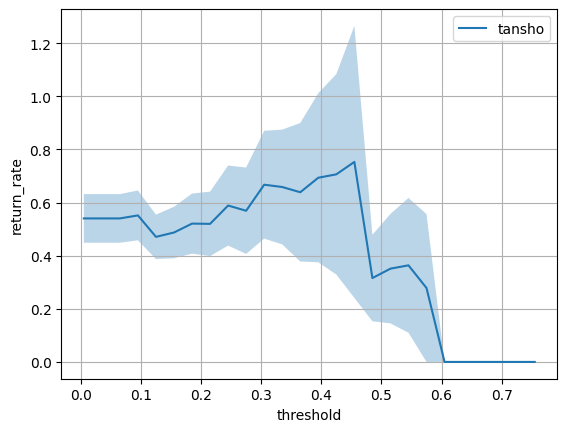

In [511]:
from src.simulation._plot import plot_single_threshold

# 回収率をプロット
plot_single_threshold(returns_df, N_SAMPLES, label="tansho")

### 5.1.2 複勝馬券

In [468]:
from src.policies._bet_policy import BetPolicyFukusho

T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
            score_table,  # スコアテーブル
            BetPolicyFukusho,  # 賭け方の方針
            threshold=threshold,  # 「馬の勝ちやすさスコア」の閾値
        )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient="index")
returns_df.index.name = "threshold"

  0%|          | 0/100 [00:00<?, ?it/s]

In [469]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20240224/fukusho.pickle')

df:           n_bets  n_races  n_hits  total_bet_amount  return_rate       std
threshold                                                                  
0.50           48       48       8                48     0.412500  0.175585
0.53           34       34       6                34     0.500000  0.241246
0.56           28       28       5                28     0.342857  0.144331
0.59           20       20       3                20     0.300000  0.164317
0.62           17       17       2                17     0.247059  0.169150


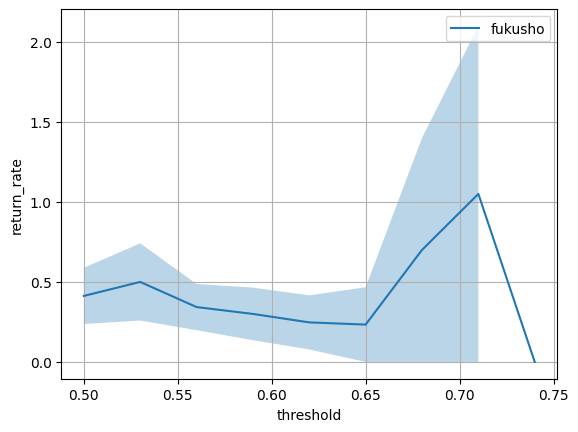

In [470]:
from src.simulation._plot import plot_single_threshold

# 回収率をプロット
plot_single_threshold(returns_df, N_SAMPLES, label="fukusho")

### 5.1.3 馬連BOX

In [505]:
from src.policies._bet_policy import BetPolicyUmarenBox

T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    # print(f"threshold:{threshold}")
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
            score_table,  # スコアテーブル
            BetPolicyUmarenBox,  # 賭け方の方針
            threshold=threshold,  # 「馬の勝ちやすさスコア」の閾値
        )
        print(f"actions{actions}")
        returns[threshold] = simulator.calc_returns(actions)
        #print(f"returns:{returns}")
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient="index")
returns_df.index.name = "threshold"

  0%|          | 0/100 [00:00<?, ?it/s]

actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}
actions{}


In [472]:


# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle("models/20240224/umarenbox.pickle")

In [473]:
from src.simulation._plot import plot_single_threshold

# 回収率をプロット
plot_single_threshold(returns_df, N_SAMPLES, label="umarenbox")

df:Empty DataFrame
Columns: []
Index: []


KeyError: 'return_rate'

<Figure size 640x480 with 0 Axes>

### 5.1.4 馬単BOX

In [474]:
from src.policies._bet_policy import BetPolicyUmatanBox

T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
            score_table,  # スコアテーブル
            BetPolicyUmatanBox,  # 賭け方の方針
            threshold=threshold,  # 「馬の勝ちやすさスコア」の閾値
        )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient="index")
returns_df.index.name = "threshold"

  0%|          | 0/100 [00:00<?, ?it/s]

In [475]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20240224/umatanbox.pickle')

In [476]:
from src.simulation._plot import plot_single_threshold

# 回収率をプロット
plot_single_threshold(returns_df, N_SAMPLES, label="umatanbox")

df:Empty DataFrame
Columns: []
Index: []


KeyError: 'return_rate'

<Figure size 640x480 with 0 Axes>

### 5.1.5 ワイドBOX

In [ ]:
from src.policies._bet_policy import BetPolicyWideBox

T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
            score_table,  # スコアテーブル
            BetPolicyWideBox,  # 賭け方の方針
            threshold=threshold,  # 「馬の勝ちやすさスコア」の閾値
        )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient="index")
returns_df.index.name = "threshold"

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20240224/widebox.pickle')

In [ ]:
from src.simulation._plot import plot_single_threshold

# 回収率をプロット
plot_single_threshold(returns_df, N_SAMPLES, label="widebox")

### 5.1.6 三連複BOX

In [477]:
from src.policies._bet_policy import BetPolicySanrenpukuBox

T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
            score_table,  # スコアテーブル
            BetPolicySanrenpukuBox,  # 賭け方の方針
            threshold=threshold,  # 「馬の勝ちやすさスコア」の閾値
        )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient="index")
returns_df.index.name = "threshold"

  0%|          | 0/100 [00:00<?, ?it/s]

In [478]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20240224/sanrenpukubox.pickle')

In [479]:
from src.simulation._plot import plot_single_threshold

# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label="sanrenpukubox")

AttributeError: module 'src.simulation' has no attribute 'plot_single_threshold'

### 5.1.7 三連単BOX

In [480]:
from src.policies._bet_policy import BetPolicySanrentanBox

T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
            score_table,  # スコアテーブル
            BetPolicySanrentanBox,  # 賭け方の方針
            threshold=threshold,  # 「馬の勝ちやすさスコア」の閾値
        )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient="index")
returns_df.index.name = "threshold"

  0%|          | 0/100 [00:00<?, ?it/s]

In [481]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20240224/sanrentanbox.pickle')

In [482]:
from src.simulation._plot import plot_single_threshold

#回収率をプロット
plot_single_threshold(returns_df, N_SAMPLES, label="sanrentanbox")

df:Empty DataFrame
Columns: []
Index: []


KeyError: 'return_rate'

<Figure size 640x480 with 0 Axes>

## 5.2. 複数馬券
未実装

## 5.3. 複数threshold
未実装だが、以下のようなコードになる予定。

In [ ]:
from src.policies._bet_policy import BetPolicyTanshoFukusho

T1_RANGE = [2.5, 3.5]
MIN_T2 = 1
N_SAMPLES = 10

returns = {}
# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
idx = 0
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold1 = T1_RANGE[1] * i / N_SAMPLES + T1_RANGE[0] * (1 - (i / N_SAMPLES))
    for j in range(N_SAMPLES):
        # MIN_T2からthreshold1までをN_SAMPLES等分
        threshold2 = threshold1 * j / N_SAMPLES + MIN_T2 * (1 - (j / N_SAMPLES))
        try:
            # print(threshold1, threshold2)
            # 賭ける馬券を決定
            actions = keiba_ai.decide_action(
                score_table,  # スコアテーブル
                BetPolicyTanshoFukusho,  # 賭け方の方針(未実装)
                threshold1=threshold1,  # 「馬の勝ちやすさスコア」の閾値
                threshold2=threshold2,
            )
            returns[idx] = simulator.calc_returns(actions)
            idx += 1
        except Exception as e:
            print(e)
            break
returns_df = pd.DataFrame.from_dict(returns, orient="index")

  0%|          | 0/10 [00:00<?, ?it/s]

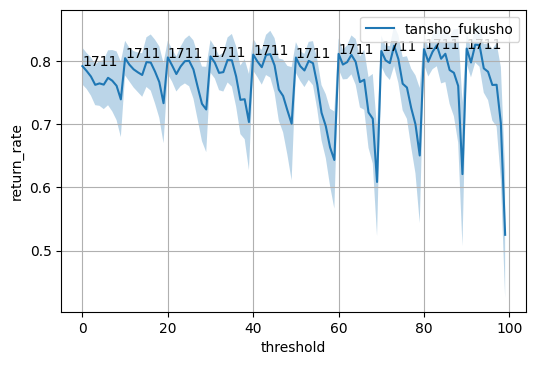

In [ ]:
simulation.plot_single_threshold(returns_df.reset_index(), 100, label='tansho_fukusho')

# 6. 当日の予想
例として2022年1月8日のレースを実際に予想する場合を考える。  
https://race.netkeiba.com/top/race_list.html?kaisai_date=20220108

## 6.1. 前日準備

In [ ]:
%autoreload

In [ ]:
race_id_list = preparing.scrape_race_id_list(['20220108']) #レースidを取得
len(race_id_list)

getting race_id_list


  0%|          | 0/1 [00:00<?, ?it/s]

scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20220108


24

In [ ]:
#出走するhorse_idの取得
horse_id_list = preparing.scrape_horse_id_list(race_id_list)
len(horse_id_list)

sraping horse_id_list


  0%|          | 0/24 [00:00<?, ?it/s]

361

In [ ]:
#horseページのhtmlをスクレイピング
#直近レースが更新されている可能性があるので、skip=Falseにして上書きする
html_files_horse = preparing.scrape_html_horse_with_master(horse_id_list, skip=False)

In [ ]:
#horse_infoテーブルの更新
horse_info_20220108 = preparing.get_rawdata_horse_info(html_files_horse)
preparing.update_rawdata(LocalPaths.RAW_HORSE_INFO_PATH, horse_info_20220108)

In [ ]:
#horse_resultsテーブルの更新
horse_results_20220108 = preparing.get_rawdata_horse_results(html_files_horse)
preparing.update_rawdata(LocalPaths.RAW_HORSE_RESULTS_PATH, horse_results_20220108)

In [ ]:
#pedsテーブルの更新
html_files_peds = preparing.scrape_html_ped(horse_id_list, skip=True)
peds_20220108 = preparing.get_rawdata_peds(html_files_peds)
preparing.update_rawdata(LocalPaths.RAW_PEDS_PATH, peds_20220108)

In [ ]:
#processorの更新
horse_info_processor = preprocessing.HorseInfoProcessor(
    filepath=LocalPaths.RAW_HORSE_INFO_PATH)
horse_results_processor = preprocessing.HorseResultsProcessor(
    filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
peds_processor = preprocessing.PedsProcessor(filepath=LocalPaths.RAW_PEDS_PATH)

In [ ]:
#モデルの準備
keiba_ai = training.KeibaAIFactory.load('models/20220626/basemodel_2018_2021.pickle')

## 6.2. 前日全レース予想

In [ ]:
%autoreload

In [ ]:
# 前日全レース予想用のレースidとレース発走時刻を取得
target_race_id_list, target_race_time_list = preparing.scrape_race_id_race_time_list('20221001')
print(len(target_race_id_list))
print(len(target_race_time_list))
yesterday = True

In [ ]:
# 一時的に出馬表を保存するパスを指定
filepath = 'data/tmp/shutuba.pickle'
today = '2022/10/01'

for race_id, race_time in zip(target_race_id_list, target_race_time_list):
    # 出馬表の取得
    preparing.scrape_shutuba_table(race_id, today, filepath)

    # 前日予想の場合
    if yesterday:
        # 前日予想の場合、馬体重を0（0）に補正
        pd2 = pd.read_pickle(filepath)
        pd2[ResultsCols.WEIGHT_AND_DIFF] = '0(0)'
        # 前日予想の場合、天候と馬場状態が公開されていない場合はこちらを有効にする
        #pd2['weather'] = '晴'
        #pd2['ground_state'] = '良'
        pd2.to_pickle(filepath)

    # 出馬表の加工
    shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)

    # テーブルのマージ
    shutuba_data_merger = preprocessing.ShutubaDataMerger(
        shutuba_table_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
    )
    shutuba_data_merger.merge()

    # 特徴量エンジニアリング
    feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger) \
        .add_interval()\
        .add_agedays()\
        .dumminize_ground_state()\
        .dumminize_race_type()\
        .dumminize_sex()\
        .dumminize_weather()\
        .encode_horse_id()\
        .encode_jockey_id()\
        .encode_trainer_id()\
        .encode_owner_id()\
        .encode_breeder_id()\
        .dumminize_kaisai()\
        .dumminize_around()\
        .dumminize_race_class()

    # 予測
    X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)

    # 当日の出走情報テーブル（前処理前）
    df_tmp = shutuba_table_processor.raw_data[:1]

    i = 0
    for num in list(Master.PLACE_DICT.values()):
        if num == race_id[4:6]:
            print(list(Master.PLACE_DICT)[i] + race_id[10:12] + 'R ' + race_time + '発走 ' + str(df_tmp.iat[0, 12])
                + str(df_tmp.iat[0, 10]) + 'm ' + str(df_tmp.iat[0, 13]) + ' ' + str(df_tmp.iat[0, 15]))
            break
        i += 1

    print(keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False))

## 6.3. レース直前データ処理（当日レース予想）

In [ ]:
%autoreload

In [ ]:
# 馬体重の発表されたレースID、レース時刻を取得（レース当日用）
target_race_id_list, target_race_time_list = preparing.create_active_race_id_list()
print((target_race_id_list))
print((target_race_time_list))

In [ ]:
# 一時的に出馬表を保存するパスを指定
filepath = 'data/tmp/shutuba.pickle'
#today = '2022/10/01'
today = datetime.datetime.now().date().strftime('%Y/%m/%d')

for race_id, race_time in zip(target_race_id_list, target_race_time_list):
    # 出馬表の取得
    preparing.scrape_shutuba_table(race_id, today, filepath)

    # 出馬表の加工
    shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)

    # テーブルのマージ
    shutuba_data_merger = preprocessing.ShutubaDataMerger(
        shutuba_table_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
    )
    shutuba_data_merger.merge()

    # 特徴量エンジニアリング
    feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger) \
        .add_interval()\
        .add_agedays()\
        .dumminize_ground_state()\
        .dumminize_race_type()\
        .dumminize_sex()\
        .dumminize_weather()\
        .encode_horse_id()\
        .encode_jockey_id()\
        .encode_trainer_id()\
        .encode_owner_id()\
        .encode_breeder_id()\
        .dumminize_kaisai()\
        .dumminize_around()\
        .dumminize_race_class()

    # 予測
    X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)

    # 当日の出走情報テーブル（前処理前）
    df_tmp = shutuba_table_processor.raw_data[:1]
    #df_tmp['race_type'] tmp.iat[0, 12]
    #df_tmp['around'] 13
    #df_tmp['weather'] 14
    #df_tmp['ground_state'] 15
    #df_tmp['race_class']16

    i = 0
    for num in list(Master.PLACE_DICT.values()):
        if num == race_id[4:6]:
            print(list(Master.PLACE_DICT)[i] + race_id[10:12] + 'R ' + race_time + '発走 ' + str(df_tmp.iat[0, 12])
                + str(df_tmp.iat[0, 10]) + 'm ' + str(df_tmp.iat[0, 13]) + ' ' + str(df_tmp.iat[0, 15]))
            break
        i += 1

    print(keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False))

## 6.4. レース直前データ処理（旧方式）

In [ ]:
filepath = 'data/tmp/shutuba.pickle' #一時的に出馬表を保存するパスを指定
preparing.scrape_shutuba_table(race_id_list[0], '2022/1/8', filepath) #馬体重が発表されたら、出馬表を取得
shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath) #出馬表の加工

In [ ]:
#テーブルのマージ
shutuba_data_merger = preprocessing.ShutubaDataMerger(
    shutuba_table_processor,
    horse_results_processor,
    horse_info_processor,
    peds_processor,
    target_cols=TARGET_COLS,
    group_cols=GROUP_COLS
)

shutuba_data_merger.merge()

separating horse results by date


  0%|          | 0/1 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#特徴量エンジニアリング
feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger)\
    .add_interval()\
    .add_agedays()\
    .dumminize_ground_state()\
    .dumminize_race_type()\
    .dumminize_sex()\
    .dumminize_weather()\
    .encode_horse_id()\
    .encode_jockey_id()\
    .encode_trainer_id()\
    .encode_owner_id()\
    .encode_breeder_id()\
    .dumminize_kaisai()\
    .dumminize_around()\
    .dumminize_race_class()

In [ ]:
#予測
X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)
keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False)

,馬番,単勝,score
202206010201,5,4.7,1.972623
202206010201,3,4.3,1.698477
202206010201,15,4.5,1.292167
202206010201,4,5.7,0.754306
202206010201,11,5.4,0.706008
202206010201,6,16.9,0.401887
202206010201,16,14.2,-0.070303
202206010201,1,26.7,-0.260754
202206010201,13,29.8,-0.300251
202206010201,9,101.3,-0.481400
